In [1]:
import numpy as np
import findiff
import itertools as it
import os
import math
import matplotlib.pyplot as plt
import pandas as pd

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
def get_input(z1, bond, pos):
    delta = 0.05
    z2 = 14 - z1
    tpl = """calc=ccsd(t)
mem=10GB
core=frozen
ccprog=mrcc
basis=cc-pVDZ
grdens=on
rgrid=Log3
grtol=10
agrid=LD0770
unit=angs
geom=xyz
2

%d 0. 0. 0.
%d %f 0. 0.
qmmm=Amber
pointcharges
2
0. 0. 0. %f
%f 0. 0. %f""" % (z1, z2, bond, -pos*delta, bond, pos*delta)
    return tpl

In [68]:
bonds = np.linspace(0.8, 1.7, 10)
zs = np.arange(1, 8)
poss = np.hstack((np.arange(-3, 4), 20))

#for bond, z, pos in it.product(bonds, zs, poss):
#    folder = 'tabular/%d/%1.1f/%d' % (z, bond, pos)
#    os.makedirs(folder, exist_ok=True)
#    with open(folder + '/MINP', 'w') as fh:
#        fh.write(get_input(z, bond, pos))

In [3]:
def _parse_densityfile(densityfile):
    with open(densityfile, "r") as fh:
        _ = np.fromfile(fh, "i4")
        q = _[3:-1].view(np.float64)
        ccdensity = q.reshape((-1, 10))
    return ccdensity[:, 1:6]
angstrom = 1 / 0.52917721067
def get_epn(z1, bond, pos):
    folder = 'tabular/%d/%1.1f/%d' % (z1, bond, pos)
    components = _parse_densityfile("%s/DENSITY" % folder)
    coordinates = np.zeros((2,3))
    coordinates[1, 0] = bond
    gridpos, gridweights, density = (
        components[:, :3],
        components[:, 3],
        components[:, 4],
    )

    epns = []
    for atomidx in range(2):
        ds = np.linalg.norm(
            gridpos - coordinates[atomidx] * angstrom, axis=1
        )
        epns.append((gridweights * density / ds).sum())
    return np.array(epns)

In [44]:
def get_dE(z1, bond, n):
    fd = findiff.coefficients(deriv=n-1, acc=2)['center']
    values = np.array([sum(get_epn(z1, bond, _)*np.array([-1, 1])) for _ in fd['offsets']])
    dE = sum(values * fd['coefficients']) / math.factorial(n)
    return dE / (0.05 ** (n-1))

In [45]:
get_dE(4, 1.0, 1)

19.203909620824746

In [93]:
def get_energy(z1, bond, pos):
    logfile = 'tabular-perturbative/%d/%1.1f/%d/run.log' % (z1, bond, pos)
    with open(logfile) as fh:
        lines = fh.readlines()
        E = float([_ for _ in lines if 'CCSD(T) total energy [au]' in _][-1].strip().split()[-1])
        NN = float([_ for _ in lines if 'Nuclear repulsion with point charges' in _][-1].strip().split()[-1])
    #print (logfile, E, NN, E-NN)
    return E-NN

In [64]:
def get_orders(z1, bond):
    Es = []
    E = get_energy(z1, bond, 0)
    #print (0, E)
    for order in range(1, 8):
        E -= get_dE(z1, bond, order)
        #print (order, E)
        Es.append(E)
    return Es, get_energy(z1, bond, 20)

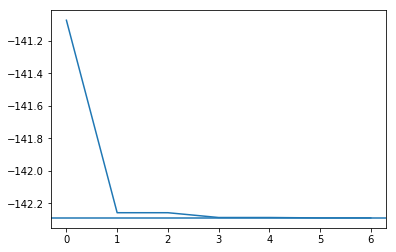

In [79]:
Es, t = get_orders(7, 0.8)
plt.plot(Es)
plt.axhline(t)

In [94]:
def build_df():
    ret = []
    for z in zs:
        for bond in bonds:
            #Es, t = get_orders(z, bond)
            t = get_energy(z, bond, 20)
            res = {'z1ref': z, 'z2ref': 14-z, 'z1tar':z-1, 'z2tar':(14-z+1), 'bond': bond, 'true': t}
            #for order in range(len(Es)):
            #    res['order%d' % order] = Es[order]
            ret.append(res)
            #break
    return pd.DataFrame(ret)

In [95]:
df = build_df()

In [98]:
df.to_csv('alchemical-pes.csv', index=False)

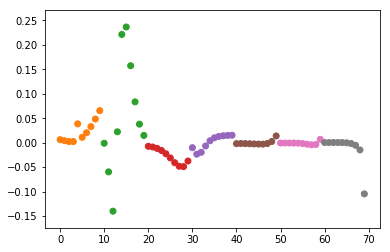

In [76]:
plt.scatter(df.index, df.true-df.order6, color=['C%d' % _ for _ in df.z1ref ])

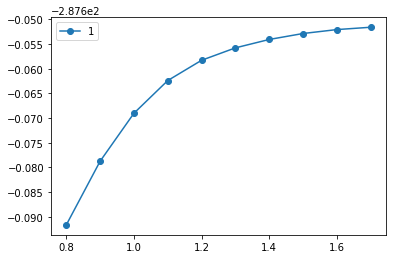

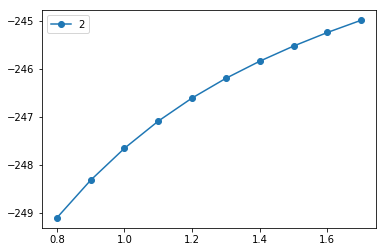

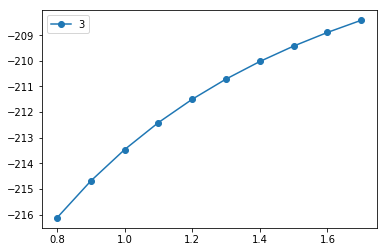

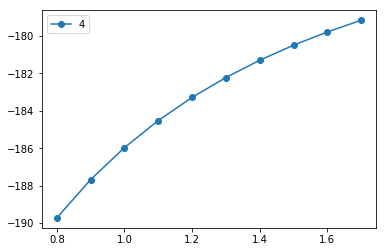

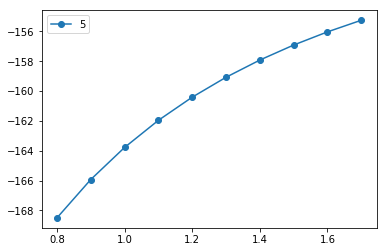

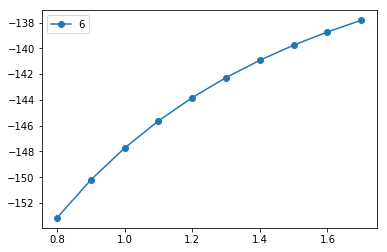

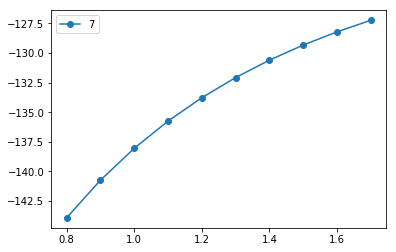

In [97]:
for name, group in df.groupby('z1ref'):
    plt.plot(group.bond, group.true, 'o-',label=name)
    plt.legend()
    plt.show()

In [23]:
number = '7316717653133062491922511967442657474235534919493496983520312774506326239578318016984801869478851843858615607891129494954595017379583319528532088055111254069874715852386305071569329096329522744304355766896648950445244523161731856403098711121722383113622298934233803081353362766142828064444866452387493035890729629049156044077239071381051585930796086670172427121883998797908792274921901699720888093776657273330010533678812202354218097512545405947522435258490771167055601360483958644670632441572215539753697817977846174064955149290862569321978468622482839722413756570560574902614079729686524145351004748216637048440319989000889524345065854122758866688116427171479924442928230863465674813919123162824586178664583591245665294765456828489128831426076900422421902267105562632111110937054421750694165896040807198403850962455444362981230987879927244284909188845801561660979191338754992005240636899125607176060588611646710940507754100225698315520005593572972571636269561882670428252483600823257530420752963450'

In [30]:
sequence_length = 13
number_starting_points = len(number) - sequence_length
largest_product = 0
for starting_point in range(number_starting_points):
    section = number[starting_point:starting_point + sequence_length]
    product = 1
    for value in section:
        product *= int(value)
    largest_product = max(product, largest_product)
largest_product

23514624000

In [ ]:
+49 7621 44959